## BASE

Training set size: 3404
Validation set size: 728
Test set size: 732
Training set company distribution:
Company
Alibaba    851
Apple      851
Philips    851
Tesla      851
Name: count, dtype: int64
Test set company distribution:
Company
Alibaba    183
Apple      183
Philips    183
Tesla      183
Name: count, dtype: int64
1D_Up Prediction Model - SVM with L1 Regularization (Baseline)
Starting hyperparameter tuning for 1D SVM model...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters for 1D model: {'C': 0.1, 'class_weight': None, 'max_iter': 10000}
Best cross-validation F1 score: 0.5282

1D Model Test Set Results:


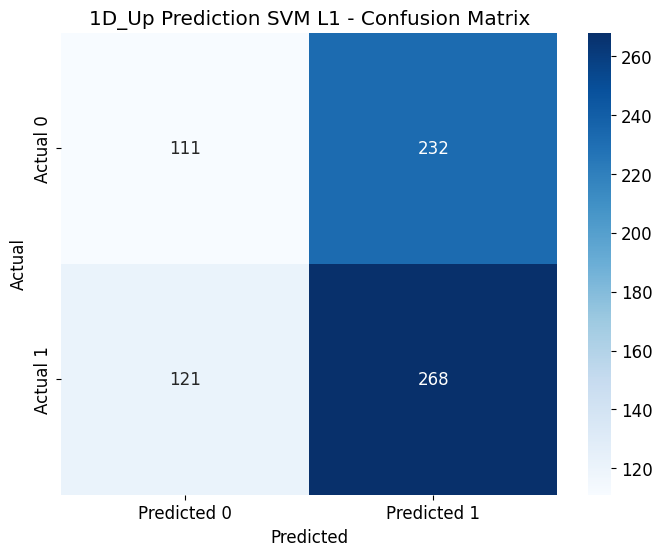

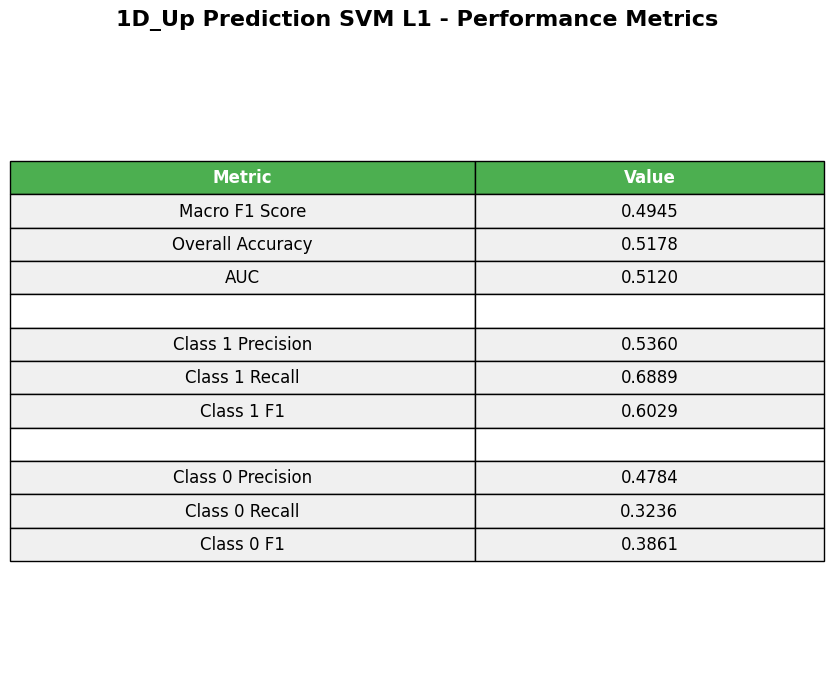


20D_Up Prediction Model - SVM with L1 Regularization (Baseline)
Starting hyperparameter tuning for 20D SVM model...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters for 20D model: {'C': 0.01, 'class_weight': None, 'max_iter': 10000}
Best cross-validation F1 score: 0.6568

20D Model Test Set Results:


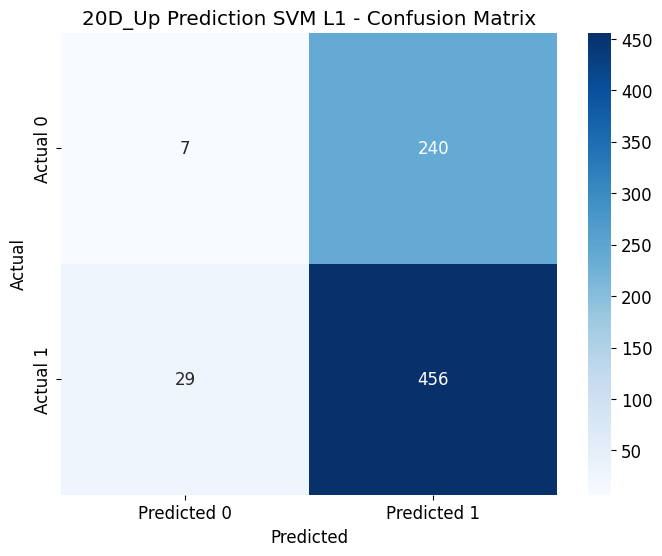

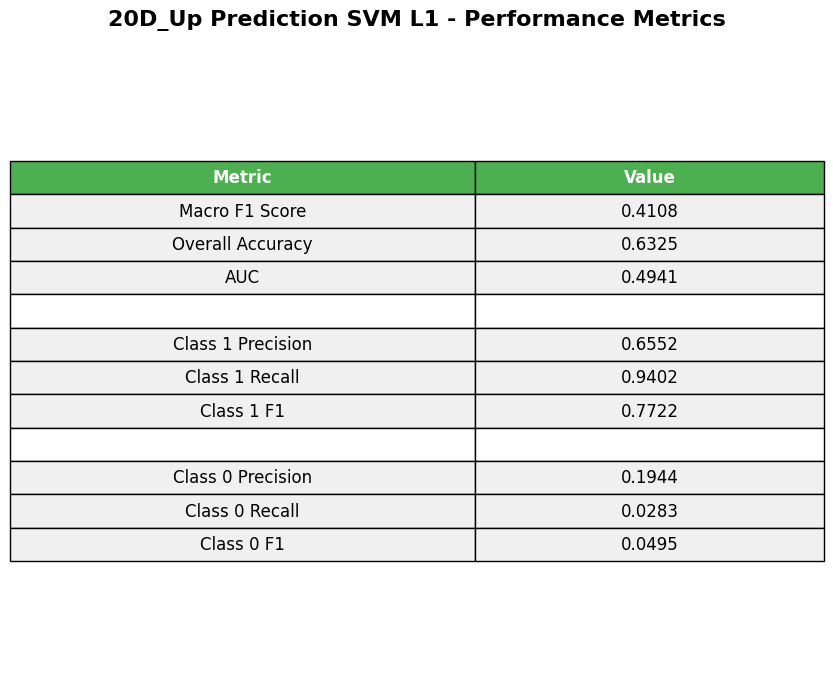


Feature Coefficients Analysis - SVM L1 Baseline


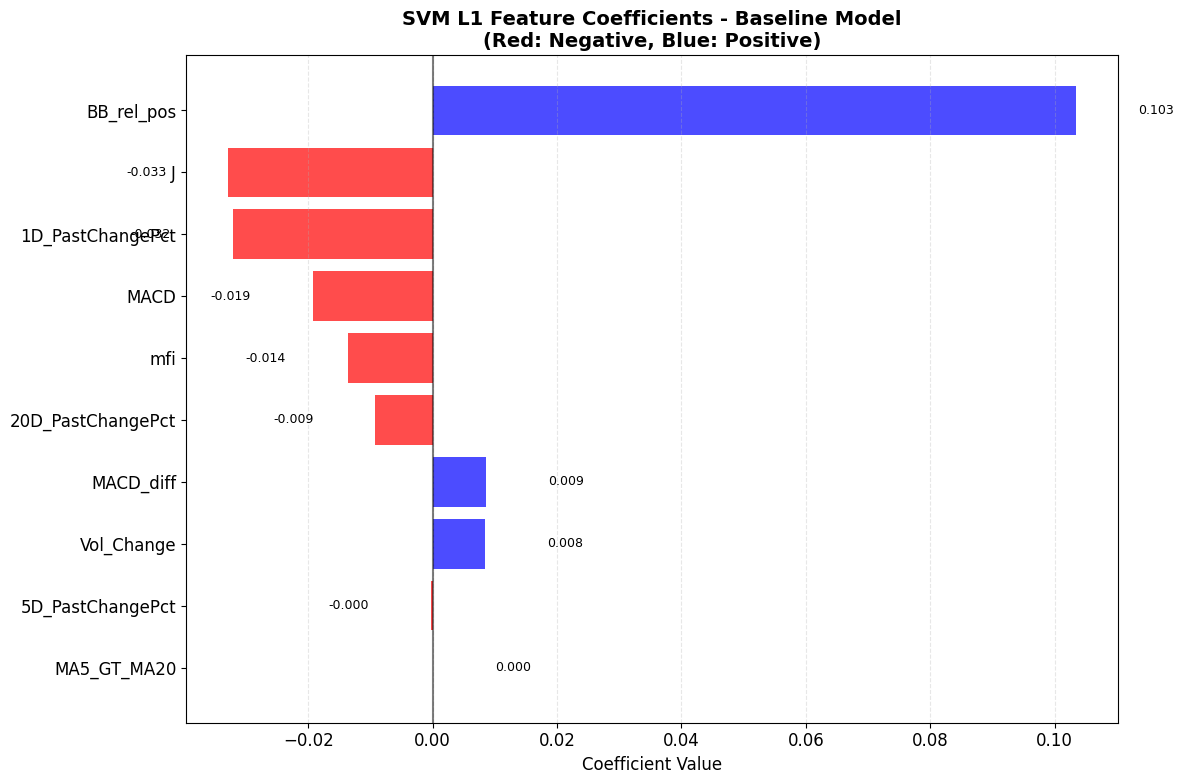


Feature Coefficients Summary:
Total features: 10
Non-zero coefficients: 9/10
Features with zero coefficients (selected out by L1): ['MA5_GT_MA20']

Largest positive coefficient: BB_rel_pos (0.1034)
Largest negative coefficient: MA5_GT_MA20 (0.0000)

Top 10 Features by Absolute Coefficient Value:
 Rank           Feature   Average
   10       MA5_GT_MA20  0.000000
    9  5D_PastChangePct -0.000181
    8        Vol_Change  0.008455
    7         MACD_diff  0.008563
    6 20D_PastChangePct -0.009178
    5               mfi -0.013578
    4              MACD -0.019208
    3  1D_PastChangePct -0.032125
    2                 J -0.032825
    1        BB_rel_pos  0.103428

Model Performance Summary
1D Model Performance:
  - Macro F1 Score: 0.4945
  - Overall Accuracy: 0.5178
  - AUC: 0.5120

20D Model Performance:
  - Macro F1 Score: 0.4108
  - Overall Accuracy: 0.6325
  - AUC: 0.4941

Average Performance Across Both Models:
  - Average Macro F1 Score: 0.4527
  - Average Accuracy: 0.5751
  - Av

In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (12, 8)

# Load data
df = pd.read_csv('DATA.csv')

# Define feature columns - Baseline model (only technical indicators)
continuous_features = ['1D_PastChangePct', '5D_PastChangePct', '20D_PastChangePct',  'J', 
                      'mfi', 'MACD', 'MACD_diff',  'BB_rel_pos', 'Vol_Change']
binary_features = ['MA5_GT_MA20']
features = continuous_features + binary_features

# Split data by company in chronological order
train_data_list = []
val_data_list = []
test_data_list = []

for company in df['Company'].unique():
    company_data = df[df['Company'] == company].copy()
    company_data = company_data.sort_values('Date')  # Ensure chronological order
    
    n_company = len(company_data)
    train_size = int(0.7 * n_company)
    val_size = int(0.15 * n_company)
    
    train_data_list.append(company_data.iloc[:train_size])
    val_data_list.append(company_data.iloc[train_size:train_size+val_size])
    test_data_list.append(company_data.iloc[train_size+val_size:])

# Concatenate all companies' data
train_data = pd.concat(train_data_list, ignore_index=True)
val_data = pd.concat(val_data_list, ignore_index=True)
test_data = pd.concat(test_data_list, ignore_index=True)

print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")
print(f"Training set company distribution:\n{train_data['Company'].value_counts().sort_index()}")
print(f"Test set company distribution:\n{test_data['Company'].value_counts().sort_index()}")

# Modified preprocessing function
def preprocess_data(train_df, val_df, test_df, target_col, continuous_features, binary_features):
    all_features = continuous_features + binary_features
    
    # Drop missing values
    train_df = train_df.dropna(subset=all_features + [target_col])
    val_df = val_df.dropna(subset=all_features + [target_col])
    test_df = test_df.dropna(subset=all_features + [target_col])
    
    # Separate continuous and binary features
    X_train_continuous = train_df[continuous_features]
    X_val_continuous = val_df[continuous_features]
    X_test_continuous = test_df[continuous_features]
    
    X_train_binary = train_df[binary_features]
    X_val_binary = val_df[binary_features]
    X_test_binary = test_df[binary_features]
    
    y_train = train_df[target_col]
    y_val = val_df[target_col]
    y_test = test_df[target_col]
    
    # Standardize only continuous features
    scaler = StandardScaler()
    X_train_continuous_scaled = scaler.fit_transform(X_train_continuous)
    X_val_continuous_scaled = scaler.transform(X_val_continuous)
    X_test_continuous_scaled = scaler.transform(X_test_continuous)
    
    # Combine scaled continuous features with unscaled binary features
    X_train_scaled = np.hstack([X_train_continuous_scaled, X_train_binary.values])
    X_val_scaled = np.hstack([X_val_continuous_scaled, X_val_binary.values])
    X_test_scaled = np.hstack([X_test_continuous_scaled, X_test_binary.values])
    
    return X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test, scaler

# Evaluation function
def evaluate_model(y_true, y_pred, y_prob, model_name):
    cm = confusion_matrix(y_true, y_pred)
    
    # Overall metrics
    f1_macro = f1_score(y_true, y_pred, average='macro')
    accuracy = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    
    # Class-specific metrics
    precision_per_class = precision_score(y_true, y_pred, average=None)
    recall_per_class = recall_score(y_true, y_pred, average=None)
    f1_per_class = f1_score(y_true, y_pred, average=None)
    
    # Confusion matrix heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f'{model_name} SVM L1 - Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    # Performance metrics table
    plt.figure(figsize=(10, 8))
    plt.axis('tight')
    plt.axis('off')
    
    table_data = [
        ['Metric', 'Value'],
        ['Macro F1 Score', f'{f1_macro:.4f}'],
        ['Overall Accuracy', f'{accuracy:.4f}'],
        ['AUC', f'{auc:.4f}'],
        ['', ''],  # Empty row for separation
        ['Class 1 Precision', f'{precision_per_class[1]:.4f}'],
        ['Class 1 Recall', f'{recall_per_class[1]:.4f}'],
        ['Class 1 F1', f'{f1_per_class[1]:.4f}'],
        ['', ''],  # Empty row for separation
        ['Class 0 Precision', f'{precision_per_class[0]:.4f}'],
        ['Class 0 Recall', f'{recall_per_class[0]:.4f}'],
        ['Class 0 F1', f'{f1_per_class[0]:.4f}']
    ]
    
    table = plt.table(cellText=table_data[1:], colLabels=table_data[0],
                     cellLoc='center', loc='center',
                     colWidths=[0.4, 0.3])
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.5, 2)
    
    # Set table style
    for i in range(len(table_data)):
        for j in range(len(table_data[0])):
            cell = table[(i, j)]
            if i == 0:  # header
                cell.set_facecolor('#4CAF50')
                cell.set_text_props(weight='bold', color='white')
            elif len(table_data[i]) > 0 and table_data[i][0] == '':  # empty rows
                cell.set_facecolor('#ffffff')
                cell.set_text_props(color='white')
            else:
                cell.set_facecolor('#f0f0f0')
    
    plt.title(f'{model_name} SVM L1 - Performance Metrics', fontsize=16, fontweight='bold', pad=20)
    plt.show()
    
    return {'confusion_matrix': cm, 'f1_macro': f1_macro, 'accuracy': accuracy, 'auc': auc,
            'class_0_precision': precision_per_class[0], 'class_0_recall': recall_per_class[0], 'class_0_f1': f1_per_class[0],
            'class_1_precision': precision_per_class[1], 'class_1_recall': recall_per_class[1], 'class_1_f1': f1_per_class[1]}

# 1D_Up prediction
print("=" * 60)
print("1D_Up Prediction Model - SVM with L1 Regularization (Baseline)")
print("=" * 60)

X_train_1d, y_train_1d, X_val_1d, y_val_1d, X_test_1d, y_test_1d, scaler_1d = preprocess_data(
    train_data, val_data, test_data, '1D_Up', continuous_features, binary_features)

# TimeSeriesSplit cross-validation for SVM hyperparameters
# Optimized for 3000 rows of data
tscv = TimeSeriesSplit(n_splits=5)
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],           # Regularization parameter
    'class_weight': [None, 'balanced'],      # Handle class imbalance
    'max_iter': [10000]                       # Sufficient iterations for convergence
}

print("Starting hyperparameter tuning for 1D SVM model...")
grid_search_1d = GridSearchCV(
    LinearSVC(penalty='l1', dual=False, random_state=42),  # L1 penalty, dual=False for L1
    param_grid, cv=tscv, scoring='f1', n_jobs=-1, verbose=1
)

grid_search_1d.fit(X_train_1d, y_train_1d)
best_params_1d = grid_search_1d.best_params_
print(f"Best parameters for 1D model: {best_params_1d}")
print(f"Best cross-validation F1 score: {grid_search_1d.best_score_:.4f}")

# Train final model with best parameters
final_svm_1d = LinearSVC(penalty='l1', dual=False, random_state=42, **best_params_1d)
final_svm_1d.fit(X_train_1d, y_train_1d)

# Use CalibratedClassifierCV to get probability estimates
calibrated_svm_1d = CalibratedClassifierCV(final_svm_1d, cv=3)
calibrated_svm_1d.fit(X_train_1d, y_train_1d)

# Evaluate on test set
y_pred_1d = calibrated_svm_1d.predict(X_test_1d)
y_prob_1d = calibrated_svm_1d.predict_proba(X_test_1d)[:, 1]

print("\n1D Model Test Set Results:")
results_1d = evaluate_model(y_test_1d, y_pred_1d, y_prob_1d, "1D_Up Prediction")

# 20D_Up prediction
print("\n" + "=" * 60)
print("20D_Up Prediction Model - SVM with L1 Regularization (Baseline)")
print("=" * 60)

X_train_20d, y_train_20d, X_val_20d, y_val_20d, X_test_20d, y_test_20d, scaler_20d = preprocess_data(
    train_data, val_data, test_data, '20D_Up', continuous_features, binary_features)

print("Starting hyperparameter tuning for 20D SVM model...")
grid_search_20d = GridSearchCV(
    LinearSVC(penalty='l1', dual=False, random_state=42),
    param_grid, cv=tscv, scoring='f1', n_jobs=-1, verbose=1
)

grid_search_20d.fit(X_train_20d, y_train_20d)
best_params_20d = grid_search_20d.best_params_
print(f"Best parameters for 20D model: {best_params_20d}")
print(f"Best cross-validation F1 score: {grid_search_20d.best_score_:.4f}")

# Train final model with best parameters
final_svm_20d = LinearSVC(penalty='l1', dual=False, random_state=42, **best_params_20d)
final_svm_20d.fit(X_train_20d, y_train_20d)

# Use CalibratedClassifierCV to get probability estimates
calibrated_svm_20d = CalibratedClassifierCV(final_svm_20d, cv=3)
calibrated_svm_20d.fit(X_train_20d, y_train_20d)

# Evaluate on test set
y_pred_20d = calibrated_svm_20d.predict(X_test_20d)
y_prob_20d = calibrated_svm_20d.predict_proba(X_test_20d)[:, 1]

print("\n20D Model Test Set Results:")
results_20d = evaluate_model(y_test_20d, y_pred_20d, y_prob_20d, "20D_Up Prediction")

# Feature Coefficients Analysis
print("\n" + "=" * 60)
print("Feature Coefficients Analysis - SVM L1 Baseline")
print("=" * 60)

# Get feature names
feature_names = continuous_features + binary_features

# Get coefficients from both models
coef_1d = final_svm_1d.coef_[0]
coef_20d = final_svm_20d.coef_[0]
avg_coef = (coef_1d + coef_20d) / 2

# Create coefficients dataframe
coef_df = pd.DataFrame({
    'Feature': feature_names,
    '1D_Model': coef_1d,
    '20D_Model': coef_20d,
    'Average': avg_coef,
    'Abs_Average': np.abs(avg_coef)
}).sort_values('Abs_Average', ascending=True)

# Plot feature coefficients
plt.figure(figsize=(12, 8))
y_pos = np.arange(len(feature_names))

# Color bars based on positive/negative coefficients
colors = ['red' if coef < 0 else 'blue' for coef in coef_df['Average']]
bars = plt.barh(y_pos, coef_df['Average'], color=colors, alpha=0.7)

# Customize the plot
plt.yticks(y_pos, coef_df['Feature'])
plt.xlabel('Coefficient Value')
plt.title('SVM L1 Feature Coefficients - Baseline Model\n(Red: Negative, Blue: Positive)', 
          fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)

# Add value labels on bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + (0.01 if width >= 0 else -0.01), bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}', ha='left' if width >= 0 else 'right', va='center', fontsize=9)

plt.tight_layout()
plt.show()

# Print coefficients summary
print(f"\nFeature Coefficients Summary:")
print(f"Total features: {len(feature_names)}")

# Features with zero coefficients (due to L1 regularization)
zero_coef_features = coef_df[coef_df['Abs_Average'] < 1e-6]['Feature'].tolist()
non_zero_features = len(feature_names) - len(zero_coef_features)

print(f"Non-zero coefficients: {non_zero_features}/{len(feature_names)}")
if zero_coef_features:
    print(f"Features with zero coefficients (selected out by L1): {zero_coef_features}")

print(f"\nLargest positive coefficient: {coef_df.iloc[-1]['Feature']} ({coef_df.iloc[-1]['Average']:.4f})")
print(f"Largest negative coefficient: {coef_df.iloc[0]['Feature']} ({coef_df.iloc[0]['Average']:.4f})")

print("\nTop 10 Features by Absolute Coefficient Value:")
top_coef = coef_df.tail(10)[['Feature', 'Average', 'Abs_Average']].copy()
top_coef['Rank'] = range(len(top_coef), 0, -1)
print(top_coef[['Rank', 'Feature', 'Average']].to_string(index=False))

# Model comparison summary
print("\n" + "=" * 60)
print("Model Performance Summary")
print("=" * 60)

print(f"1D Model Performance:")
print(f"  - Macro F1 Score: {results_1d['f1_macro']:.4f}")
print(f"  - Overall Accuracy: {results_1d['accuracy']:.4f}")
print(f"  - AUC: {results_1d['auc']:.4f}")

print(f"\n20D Model Performance:")
print(f"  - Macro F1 Score: {results_20d['f1_macro']:.4f}")
print(f"  - Overall Accuracy: {results_20d['accuracy']:.4f}")
print(f"  - AUC: {results_20d['auc']:.4f}")

# Calculate average performance
avg_f1 = (results_1d['f1_macro'] + results_20d['f1_macro']) / 2
avg_accuracy = (results_1d['accuracy'] + results_20d['accuracy']) / 2
avg_auc = (results_1d['auc'] + results_20d['auc']) / 2

print(f"\nAverage Performance Across Both Models:")
print(f"  - Average Macro F1 Score: {avg_f1:.4f}")
print(f"  - Average Accuracy: {avg_accuracy:.4f}")
print(f"  - Average AUC: {avg_auc:.4f}")

print("\n" + "=" * 60)
print("SVM L1 Baseline Model Analysis Complete!")
print("=" * 60)

Training set size: 3404
Validation set size: 728
Test set size: 732
SVM L1 with Interest Rate
Training 1D SVM model...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters 1D: {'C': 0.1, 'class_weight': None, 'max_iter': 10000}


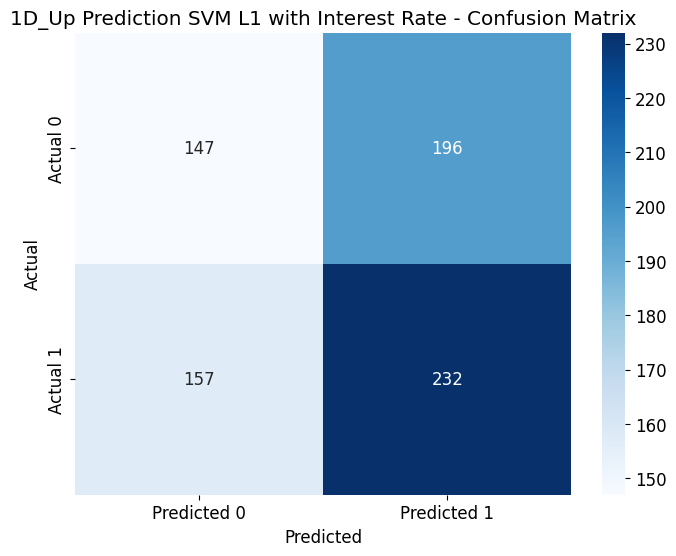

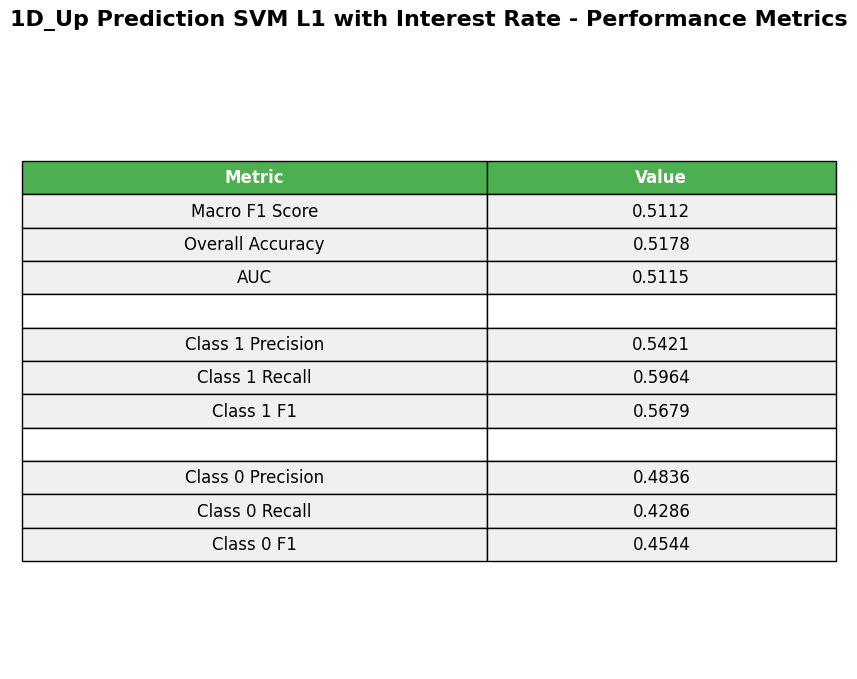

Training 20D SVM model...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters 20D: {'C': 0.01, 'class_weight': None, 'max_iter': 10000}


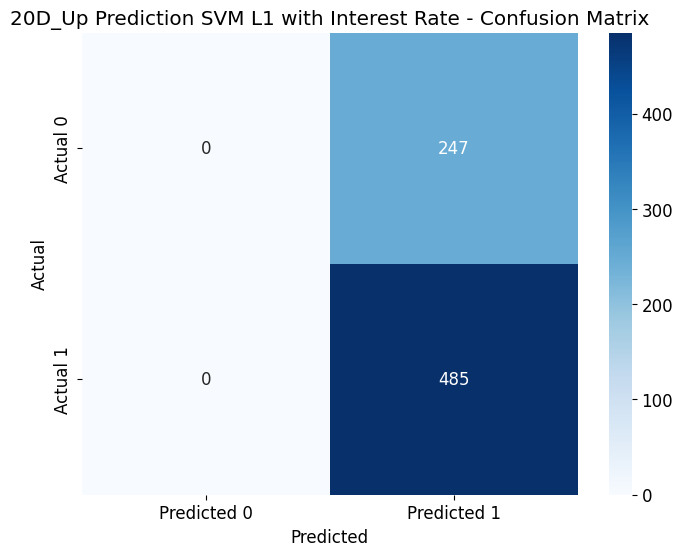

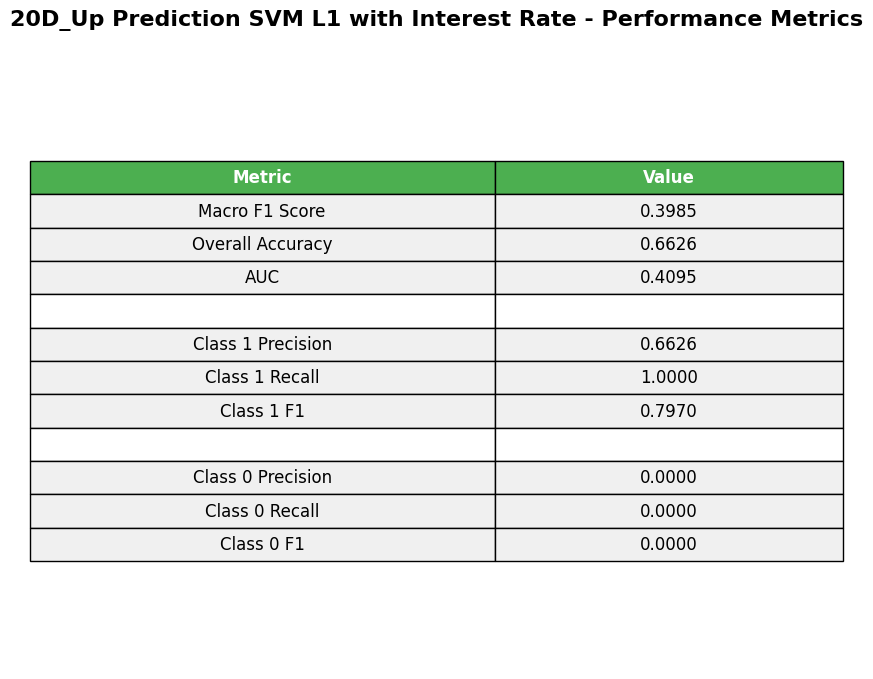


Feature Coefficients Analysis


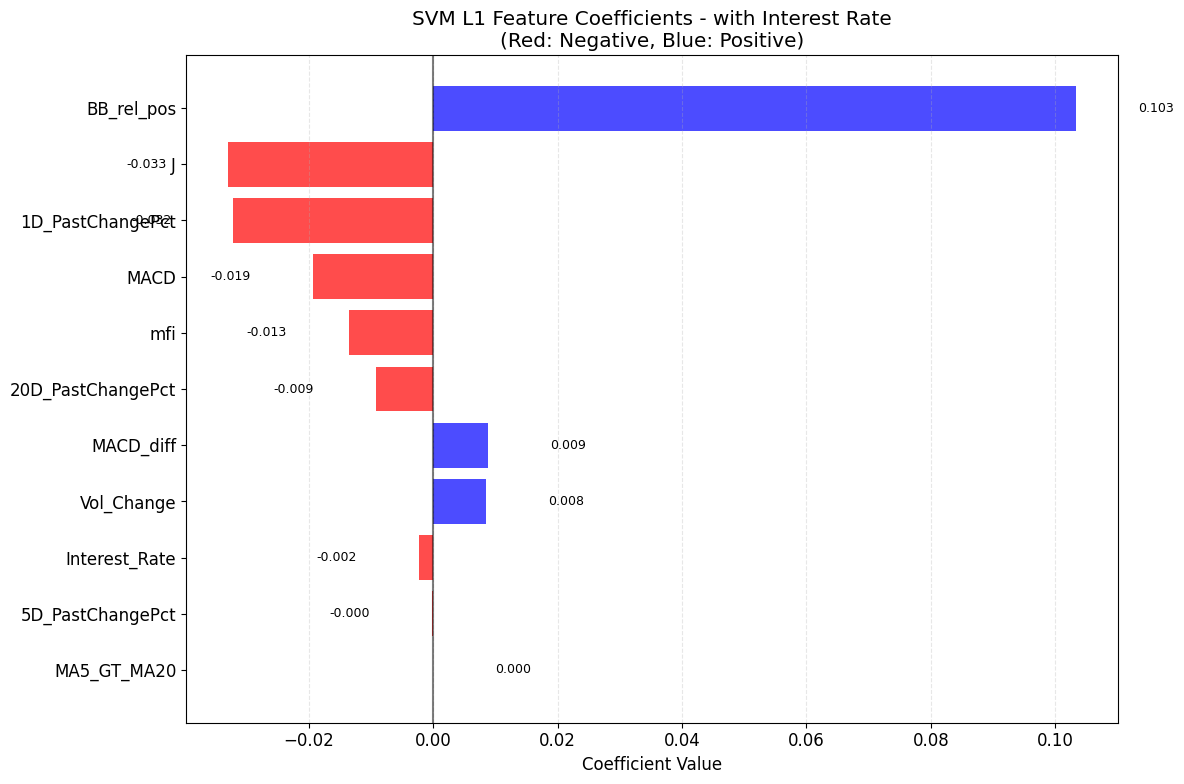

Non-zero coefficients: 10/11
Features with zero coefficients: ['MA5_GT_MA20']

Top 10 Features by Absolute Coefficient Value:
          Feature   Average
 5D_PastChangePct -0.000147
    Interest_Rate -0.002240
       Vol_Change  0.008423
        MACD_diff  0.008747
20D_PastChangePct -0.009178
              mfi -0.013490
             MACD -0.019395
 1D_PastChangePct -0.032112
                J -0.032928
       BB_rel_pos  0.103357
Training set size: 3404
Validation set size: 728
Test set size: 732
SVM L1 with BTC
Training 1D SVM model...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters 1D: {'C': 0.1, 'class_weight': None, 'max_iter': 10000}


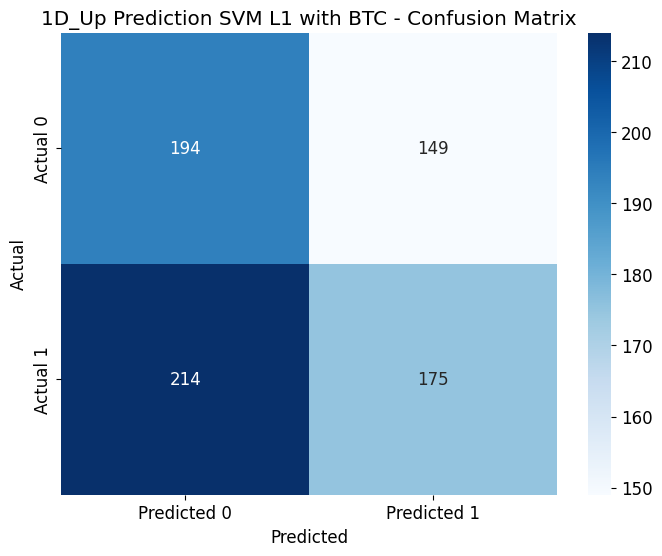

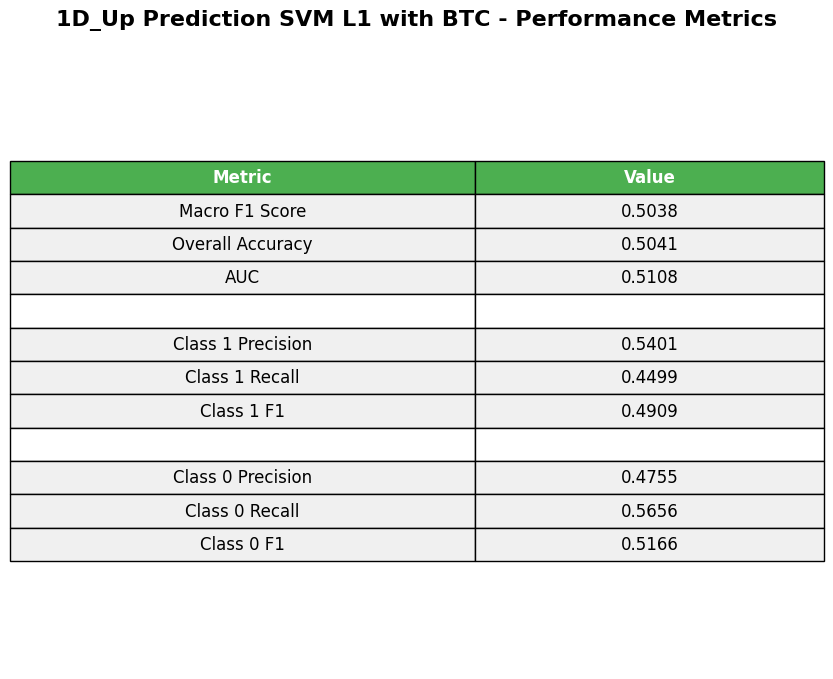

Training 20D SVM model...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters 20D: {'C': 0.01, 'class_weight': None, 'max_iter': 10000}


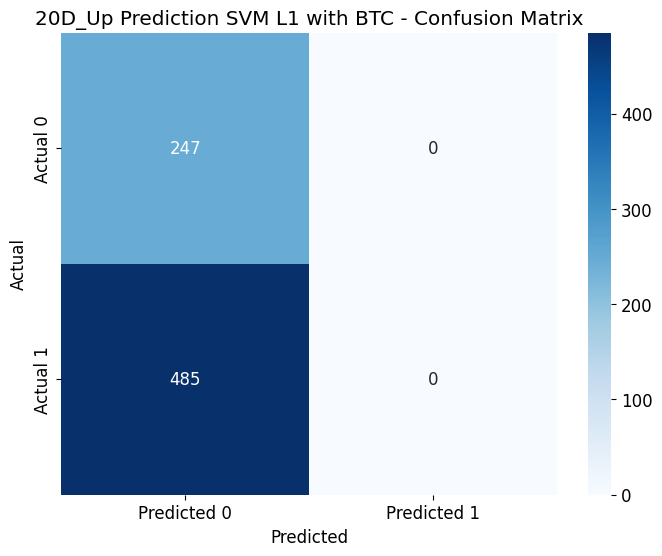

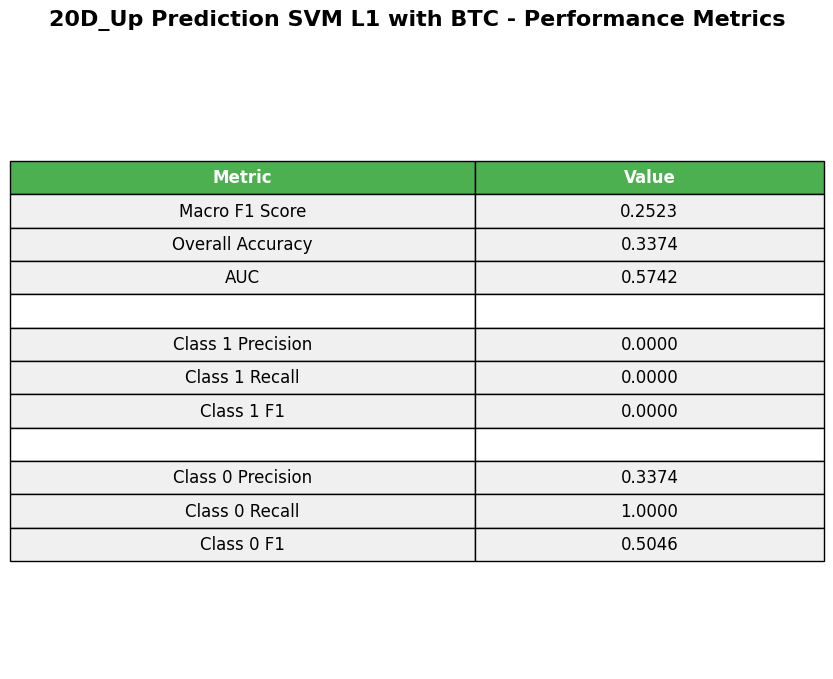


Feature Coefficients Analysis


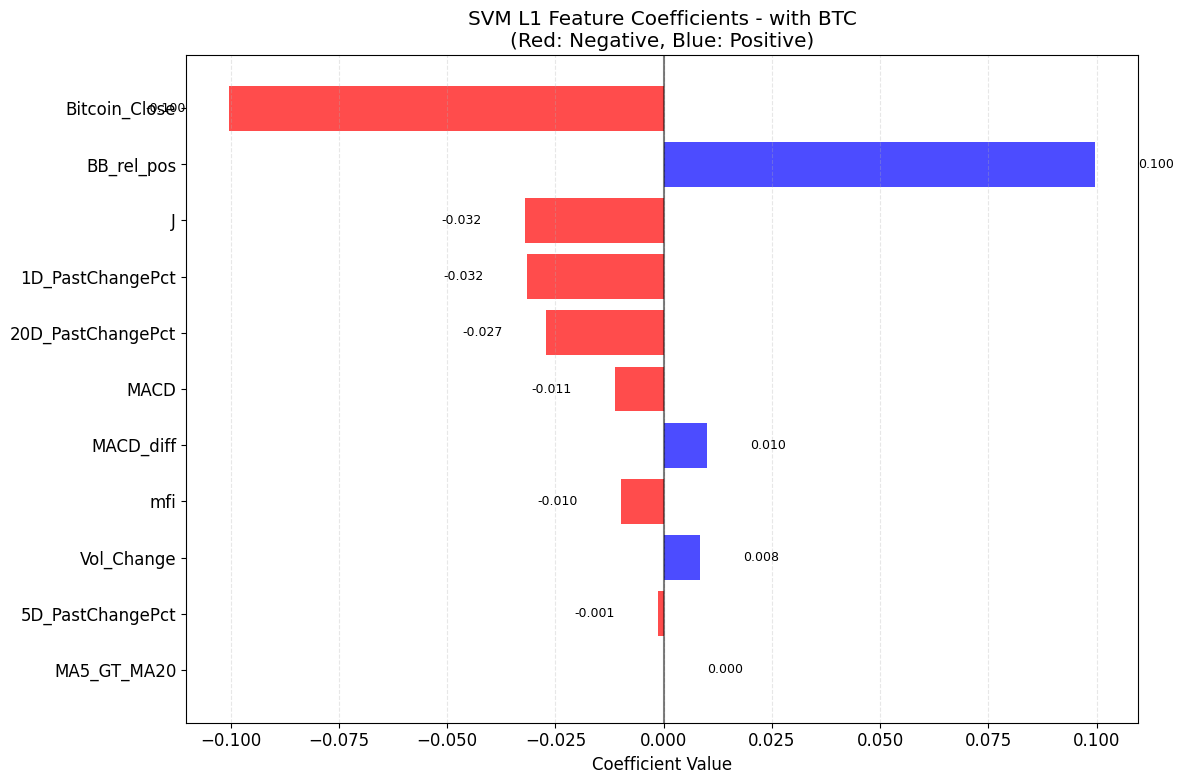

Non-zero coefficients: 10/11
Features with zero coefficients: ['MA5_GT_MA20']

Top 10 Features by Absolute Coefficient Value:
          Feature   Average
 5D_PastChangePct -0.001281
       Vol_Change  0.008443
              mfi -0.009811
        MACD_diff  0.010061
             MACD -0.011275
20D_PastChangePct -0.027229
 1D_PastChangePct -0.031618
                J -0.032024
       BB_rel_pos  0.099584
    Bitcoin_Close -0.100325
Training set size: 3404
Validation set size: 728
Test set size: 732
SVM L1 with Gold
Training 1D SVM model...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters 1D: {'C': 0.1, 'class_weight': None, 'max_iter': 10000}


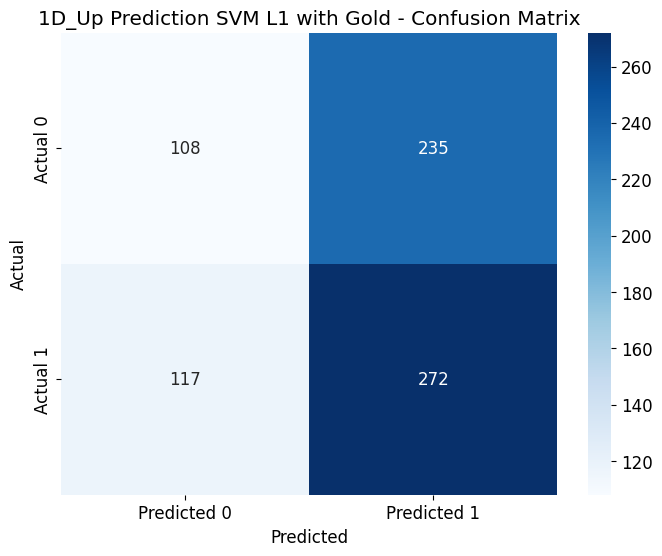

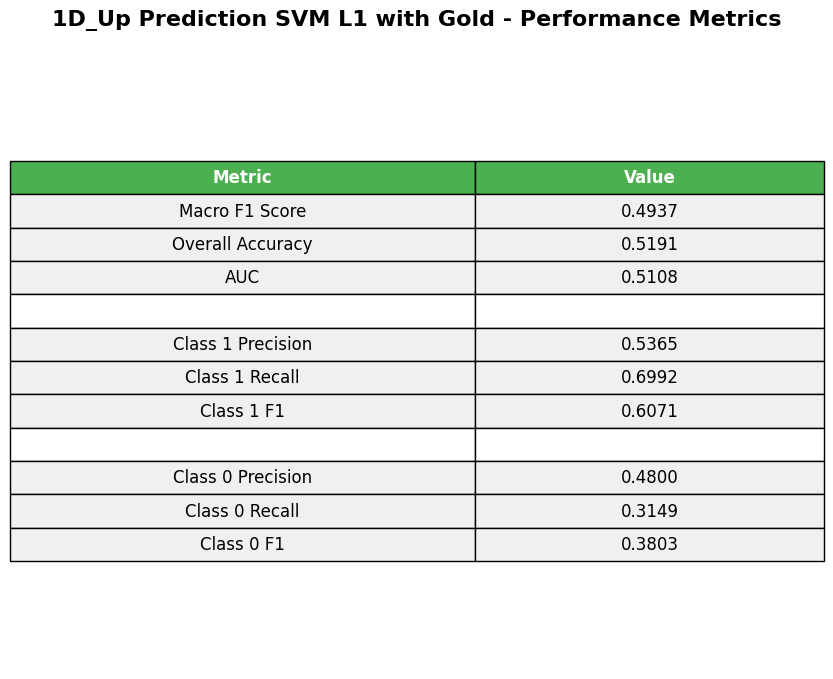

Training 20D SVM model...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters 20D: {'C': 0.01, 'class_weight': None, 'max_iter': 10000}


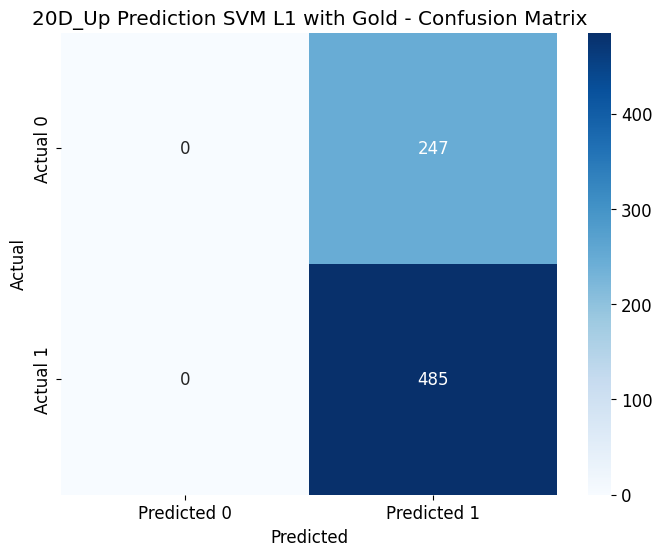

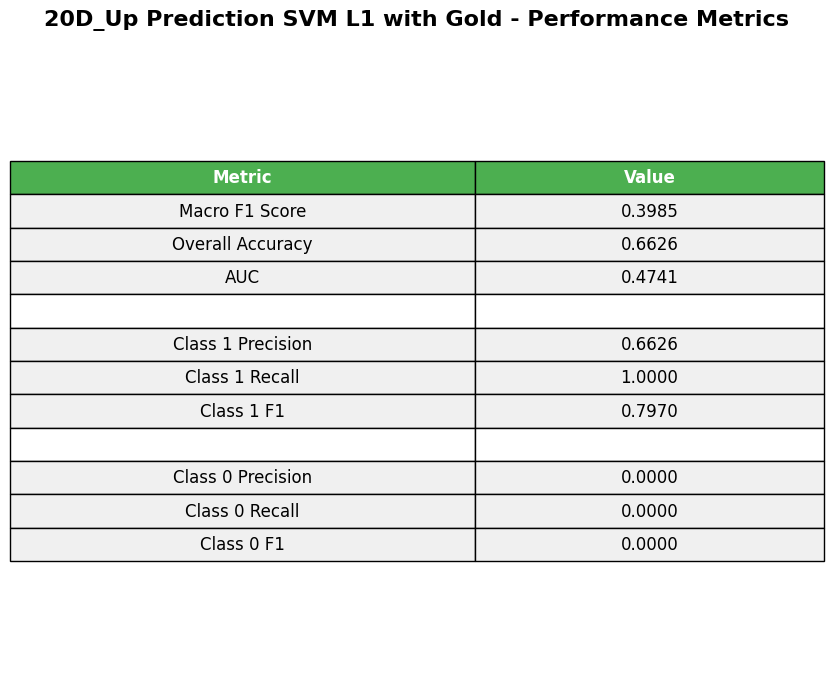


Feature Coefficients Analysis


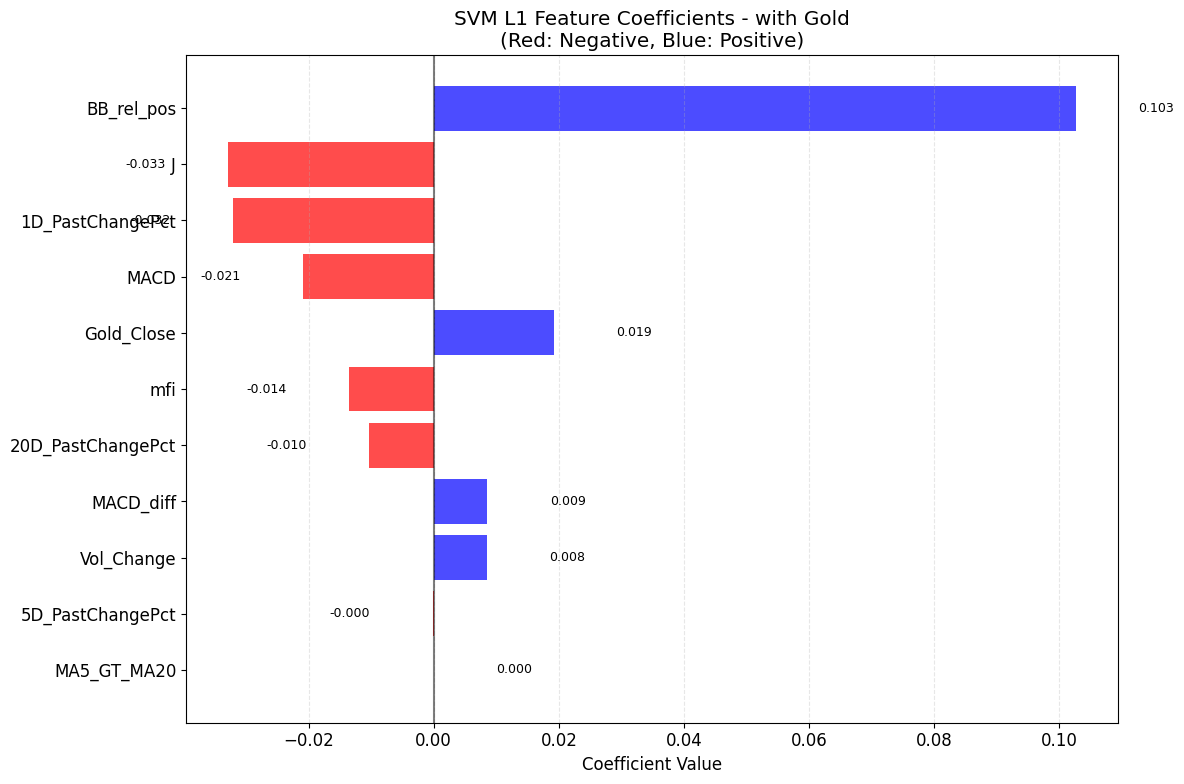

Non-zero coefficients: 10/11
Features with zero coefficients: ['MA5_GT_MA20']

Top 10 Features by Absolute Coefficient Value:
          Feature   Average
 5D_PastChangePct -0.000188
       Vol_Change  0.008454
        MACD_diff  0.008570
20D_PastChangePct -0.010280
              mfi -0.013511
       Gold_Close  0.019192
             MACD -0.020871
 1D_PastChangePct -0.032124
                J -0.032821
       BB_rel_pos  0.102606


In [2]:
import pandas as pd
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (12, 8)

def run_svm_model(df, continuous_features, binary_features, model_name, title_suffix):
    """Generic SVM L1 regularization model training and evaluation function"""
    
    # Data splitting
    train_data_list = []
    val_data_list = []
    test_data_list = []

    for company in df['Company'].unique():
        company_data = df[df['Company'] == company].copy()
        company_data = company_data.sort_values('Date')
        
        n_company = len(company_data)
        train_size = int(0.7 * n_company)
        val_size = int(0.15 * n_company)
        
        train_data_list.append(company_data.iloc[:train_size])
        val_data_list.append(company_data.iloc[train_size:train_size+val_size])
        test_data_list.append(company_data.iloc[train_size+val_size:])

    train_data = pd.concat(train_data_list, ignore_index=True)
    val_data = pd.concat(val_data_list, ignore_index=True)
    test_data = pd.concat(test_data_list, ignore_index=True)

    print(f"Training set size: {len(train_data)}")
    print(f"Validation set size: {len(val_data)}")
    print(f"Test set size: {len(test_data)}")
    
    # Data preprocessing
    def preprocess_data(train_df, val_df, test_df, target_col, continuous_features, binary_features):
        all_features = continuous_features + binary_features
        
        train_df = train_df.dropna(subset=all_features + [target_col])
        val_df = val_df.dropna(subset=all_features + [target_col])
        test_df = test_df.dropna(subset=all_features + [target_col])
        
        X_train_continuous = train_df[continuous_features]
        X_val_continuous = val_df[continuous_features]
        X_test_continuous = test_df[continuous_features]
        
        X_train_binary = train_df[binary_features]
        X_val_binary = val_df[binary_features]
        X_test_binary = test_df[binary_features]
        
        y_train = train_df[target_col]
        y_val = val_df[target_col]
        y_test = test_df[target_col]
        
        scaler = StandardScaler()
        X_train_continuous_scaled = scaler.fit_transform(X_train_continuous)
        X_val_continuous_scaled = scaler.transform(X_val_continuous)
        X_test_continuous_scaled = scaler.transform(X_test_continuous)
        
        X_train_scaled = np.hstack([X_train_continuous_scaled, X_train_binary.values])
        X_val_scaled = np.hstack([X_val_continuous_scaled, X_val_binary.values])
        X_test_scaled = np.hstack([X_test_continuous_scaled, X_test_binary.values])
        
        return X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test, scaler

    def evaluate_model(y_true, y_pred, y_prob, model_name):
        cm = confusion_matrix(y_true, y_pred)
        f1_macro = f1_score(y_true, y_pred, average='macro')
        accuracy = accuracy_score(y_true, y_pred)
        auc = roc_auc_score(y_true, y_prob)
        precision_per_class = precision_score(y_true, y_pred, average=None)
        recall_per_class = recall_score(y_true, y_pred, average=None)
        f1_per_class = f1_score(y_true, y_pred, average=None)
        
        # Confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['Predicted 0', 'Predicted 1'],
                    yticklabels=['Actual 0', 'Actual 1'])
        plt.title(f'{model_name} SVM L1 {title_suffix} - Confusion Matrix')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()
        
        # Performance metrics table
        plt.figure(figsize=(10, 8))
        plt.axis('tight')
        plt.axis('off')
        
        table_data = [
            ['Metric', 'Value'],
            ['Macro F1 Score', f'{f1_macro:.4f}'],
            ['Overall Accuracy', f'{accuracy:.4f}'],
            ['AUC', f'{auc:.4f}'],
            ['', ''],
            ['Class 1 Precision', f'{precision_per_class[1]:.4f}'],
            ['Class 1 Recall', f'{recall_per_class[1]:.4f}'],
            ['Class 1 F1', f'{f1_per_class[1]:.4f}'],
            ['', ''],
            ['Class 0 Precision', f'{precision_per_class[0]:.4f}'],
            ['Class 0 Recall', f'{recall_per_class[0]:.4f}'],
            ['Class 0 F1', f'{f1_per_class[0]:.4f}']
        ]
        
        table = plt.table(cellText=table_data[1:], colLabels=table_data[0],
                         cellLoc='center', loc='center', colWidths=[0.4, 0.3])
        table.auto_set_font_size(False)
        table.set_fontsize(12)
        table.scale(1.5, 2)
        
        for i in range(len(table_data)):
            for j in range(len(table_data[0])):
                cell = table[(i, j)]
                if i == 0:
                    cell.set_facecolor('#4CAF50')
                    cell.set_text_props(weight='bold', color='white')
                elif len(table_data[i]) > 0 and table_data[i][0] == '':
                    cell.set_facecolor('#ffffff')
                    cell.set_text_props(color='white')
                else:
                    cell.set_facecolor('#f0f0f0')
        
        plt.title(f'{model_name} SVM L1 {title_suffix} - Performance Metrics', fontsize=16, fontweight='bold', pad=20)
        plt.show()
        
        return {'confusion_matrix': cm, 'f1_macro': f1_macro, 'accuracy': accuracy, 'auc': auc,
                'class_0_precision': precision_per_class[0], 'class_0_recall': recall_per_class[0], 'class_0_f1': f1_per_class[0],
                'class_1_precision': precision_per_class[1], 'class_1_recall': recall_per_class[1], 'class_1_f1': f1_per_class[1]}

    # Model training
    print("=" * 60)
    print(f"SVM L1 {model_name}")
    print("=" * 60)
    
    # SVM hyperparameter grid
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'class_weight': [None, 'balanced'],
        'max_iter': [10000]
    }
    
    tscv = TimeSeriesSplit(n_splits=5)
    
    # 1D model
    X_train_1d, y_train_1d, X_val_1d, y_val_1d, X_test_1d, y_test_1d, scaler_1d = preprocess_data(
        train_data, val_data, test_data, '1D_Up', continuous_features, binary_features)
    
    print("Training 1D SVM model...")
    grid_search_1d = GridSearchCV(
        LinearSVC(penalty='l1', dual=False, random_state=42),
        param_grid, cv=tscv, scoring='f1', n_jobs=-1, verbose=1
    )
    
    grid_search_1d.fit(X_train_1d, y_train_1d)
    best_params_1d = grid_search_1d.best_params_
    print(f"Best parameters 1D: {best_params_1d}")
    
    final_svm_1d = LinearSVC(penalty='l1', dual=False, random_state=42, **best_params_1d)
    final_svm_1d.fit(X_train_1d, y_train_1d)
    
    calibrated_svm_1d = CalibratedClassifierCV(final_svm_1d, cv=3)
    calibrated_svm_1d.fit(X_train_1d, y_train_1d)
    
    y_pred_1d = calibrated_svm_1d.predict(X_test_1d)
    y_prob_1d = calibrated_svm_1d.predict_proba(X_test_1d)[:, 1]
    
    results_1d = evaluate_model(y_test_1d, y_pred_1d, y_prob_1d, "1D_Up Prediction")
    
    # 20D model
    X_train_20d, y_train_20d, X_val_20d, y_val_20d, X_test_20d, y_test_20d, scaler_20d = preprocess_data(
        train_data, val_data, test_data, '20D_Up', continuous_features, binary_features)
    
    print("Training 20D SVM model...")
    grid_search_20d = GridSearchCV(
        LinearSVC(penalty='l1', dual=False, random_state=42),
        param_grid, cv=tscv, scoring='f1', n_jobs=-1, verbose=1
    )
    
    grid_search_20d.fit(X_train_20d, y_train_20d)
    best_params_20d = grid_search_20d.best_params_
    print(f"Best parameters 20D: {best_params_20d}")
    
    final_svm_20d = LinearSVC(penalty='l1', dual=False, random_state=42, **best_params_20d)
    final_svm_20d.fit(X_train_20d, y_train_20d)
    
    calibrated_svm_20d = CalibratedClassifierCV(final_svm_20d, cv=3)
    calibrated_svm_20d.fit(X_train_20d, y_train_20d)
    
    y_pred_20d = calibrated_svm_20d.predict(X_test_20d)
    y_prob_20d = calibrated_svm_20d.predict_proba(X_test_20d)[:, 1]
    
    results_20d = evaluate_model(y_test_20d, y_pred_20d, y_prob_20d, "20D_Up Prediction")
    
    # Coefficient analysis
    print("\n" + "=" * 50)
    print("Feature Coefficients Analysis")
    print("=" * 50)
    
    feature_names = continuous_features + binary_features
    coef_1d = final_svm_1d.coef_[0]
    coef_20d = final_svm_20d.coef_[0]
    avg_coef = (coef_1d + coef_20d) / 2
    
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        '1D_Model': coef_1d,
        '20D_Model': coef_20d,
        'Average': avg_coef,
        'Abs_Average': np.abs(avg_coef)
    }).sort_values('Abs_Average', ascending=True)
    
    plt.figure(figsize=(12, max(8, len(feature_names)*0.4)))
    y_pos = np.arange(len(feature_names))
    
    colors = ['red' if coef < 0 else 'blue' for coef in coef_df['Average']]
    bars = plt.barh(y_pos, coef_df['Average'], color=colors, alpha=0.7)
    
    plt.yticks(y_pos, coef_df['Feature'])
    plt.xlabel('Coefficient Value')
    plt.title(f'SVM L1 Feature Coefficients - {model_name}\n(Red: Negative, Blue: Positive)')
    plt.grid(axis='x', alpha=0.3, linestyle='--')
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)
    
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width + (0.01 if width >= 0 else -0.01), bar.get_y() + bar.get_height()/2, 
                 f'{width:.3f}', ha='left' if width >= 0 else 'right', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Coefficient statistics
    zero_coef_features = coef_df[coef_df['Abs_Average'] < 1e-6]['Feature'].tolist()
    non_zero_features = len(feature_names) - len(zero_coef_features)
    
    print(f"Non-zero coefficients: {non_zero_features}/{len(feature_names)}")
    if zero_coef_features:
        print(f"Features with zero coefficients: {zero_coef_features}")
    
    print(f"\nTop 10 Features by Absolute Coefficient Value:")
    top_coef = coef_df.tail(10)[['Feature', 'Average']].copy()
    print(top_coef.to_string(index=False))
    
    return results_1d, results_20d

# Load data
df = pd.read_csv('DATA.csv')


# =============================================================================
# Version 2: Interest Rate continuous variable
# =============================================================================
continuous_features_ir = ['1D_PastChangePct', '5D_PastChangePct', '20D_PastChangePct',  'J', 
                          'mfi', 'MACD', 'MACD_diff',  'BB_rel_pos', 'Vol_Change', 'Interest_Rate']
binary_features_base = ['MA5_GT_MA20']

results_ir = run_svm_model(df, continuous_features_ir, binary_features_base, 
                          "with Interest Rate", "with Interest Rate")

# =============================================================================
# Version 3: btc
# =============================================================================
continuous_features_btc = ['1D_PastChangePct', '5D_PastChangePct', '20D_PastChangePct',  'J', 
                          'mfi', 'MACD', 'MACD_diff',  'BB_rel_pos', 'Vol_Change', 'Bitcoin_Close']
binary_features_base = ['MA5_GT_MA20']

results_btc = run_svm_model(df, continuous_features_btc, binary_features_base, 
                          "with BTC", "with BTC")

# =============================================================================
# Version 4: gold
# =============================================================================
continuous_features_gold = ['1D_PastChangePct', '5D_PastChangePct', '20D_PastChangePct',  'J', 
                          'mfi', 'MACD', 'MACD_diff',  'BB_rel_pos', 'Vol_Change', 'Gold_Close']
binary_features_base = ['MA5_GT_MA20']

results_gold = run_svm_model(df, continuous_features_gold, binary_features_base, 
                          "with Gold", "with Gold")

